### Imports

In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model
import keras as k

import sklearn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from keras.initializers import *

from matplotlib import pyplot as plt
import seaborn as sns
import scipy

from datetime import datetime

import pickle

from PIL import Image

from custom_class import *

print(f"pd.__version__: {pd.__version__}")
print(f"tf.__version__: {tf.__version__}")

2025-03-06 22:57:58.947877: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 22:57:58.981429: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-06 22:57:58.981466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-06 22:57:58.982396: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 22:57:58.989553: I tensorflow/core/platform/cpu_feature_guar

pd.__version__: 2.2.3
tf.__version__: 2.15.1


### Read file path and labels to list

In [2]:
dataset_dir = "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Dataset/machine-learning-in-science-ii-2025"
# dataset_dir = "/kaggle/input/machine-learning-in-science-ii-2025"

csv_path = os.path.join(dataset_dir, "training_norm.csv")
csv_df = pd.read_csv(csv_path, index_col="image_id")

training_data_dir = os.path.join(dataset_dir, "training_data", "training_data")

# there is one speed > 1. So change it.
csv_df.loc[csv_df["speed"] > 1, "speed"] = 1

csv_df.drop(columns=["angle"], inplace=True)

display(csv_df)

,speed
image_id,
1,0.0
2,1.0
3,1.0
4,1.0
5,0.0
...,...
13794,1.0
13795,1.0
13796,0.0


Check the data

(array([ 3390.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 10403.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

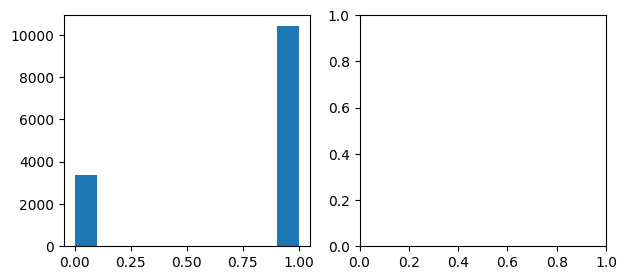

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].hist(csv_df["speed"])

In [4]:
# for rs in range(10000):
#     X = np.array(csv_df.index)
#     y = np.array(csv_df['angle'])
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=rs)
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=(0.15/0.85), random_state=rs)

#     # print(X_train.shape)
#     # print(X_val.shape)
#     # print(X_test.shape)
#     # print(X.shape)

#     train_count = pd.Series(y_train).value_counts()
#     train_count = train_count / sum(train_count) * 100
#     # val_count = pd.Series(y_val).value_counts()
#     # val_count = val_count / sum(val_count) * 100
#     # test_count = pd.Series(y_test).value_counts()
#     # test_count = test_count / sum(test_count) * 100

#     ori_count = pd.Series(y).value_counts()
#     ori_count = ori_count / sum(ori_count) * 100

#     diff = (sum(abs(train_count-ori_count)))

#     if (diff < 0.6):
#         print(f"random state: {rs}")
#         print(diff)

#     bar_width = 0.015
#     # plt.bar(val_count.index-bar_width, train_count, width=bar_width)
#     # plt.bar(train_count.index, train_count, width=bar_width)
#     # plt.bar(ori_count.index+bar_width, train_count, width=bar_width)
#     # plt.bar(test_count.index+bar_width, train_count, width=bar_width)

<BarContainer object of 2 artists>

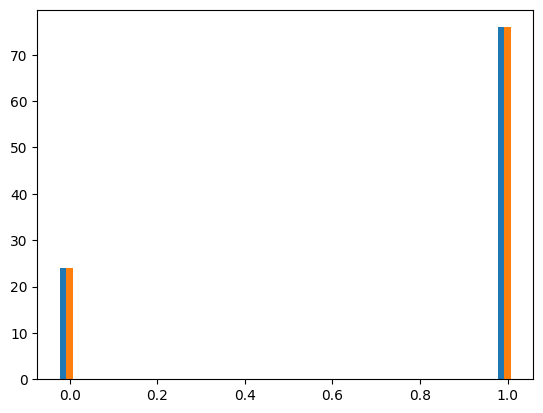

In [5]:
rs = 575

X = np.array(csv_df.index)
y = np.array(csv_df["speed"])

# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size=0.15, random_state=rs
# )

# First split into 2/3 and 1/3
X_temp, X1, y_temp, y1 = train_test_split(
    X, y, 
    test_size=1/3, 
    random_state=42
)

# Split the 2/3 into two parts (each 1/3 of original)
X2, X3, y2, y3 = train_test_split(
    X_temp, y_temp,
    test_size=0.5,  # 0.5 of 2/3 is 1/3 of original
    random_state=42
)

# Assign to train and validation sets
# Using X1 (1/3) as validation
X_train = X3
y_train = y3

# Using X2 (1/3) and X3 (1/3) combined as training (2/3 total)

X_val= np.concatenate([X1, X2])
y_val = np.concatenate([y1, y2])

train_count = pd.Series(y_train).value_counts()
train_count = train_count / sum(train_count) * 100
val_count = pd.Series(y_val).value_counts()
val_count = val_count / sum(val_count) * 100
# test_count = pd.Series(y_test).value_counts()
# test_count = test_count / sum(test_count) * 100

# print(train_count)
# print(val_count)
# print(test_count)

ori_count = pd.Series(y).value_counts()
ori_count = ori_count / sum(ori_count) * 100

# print(ori_count)

diff = sum(abs(train_count - ori_count))

# diff = (abs(train_count[0] - test_count[0]) + abs(train_count[0]-val_count[0]))

if (diff < 0.1):
    print(rs, diff)



# if diff < 0.7:
#     print(f"random state: {rs}")
#     print(diff)

bar_width = 0.015
plt.bar(val_count.index - bar_width, train_count, width=bar_width)
plt.bar(train_count.index, train_count, width=bar_width)
# plt.bar(ori_count.index+bar_width, train_count, width=bar_width)
# plt.bar(test_count.index + bar_width, train_count, width=bar_width)

In [6]:
# sample_probs_tensor = tf.constant(p_for_random_choice, dtype=tf.float32)

# X_train_tensor = tf.constant(X_train, dtype=tf.int32)
# y_train_tensor = tf.constant(y_train, dtype=tf.float32)

# NUM_SAMPLES = 32*400

# def sample_indices():
#     return tf.random.categorical(tf.math.log([sample_probs_tensor]), NUM_SAMPLES)[0]

# sampled_indices = sample_indices()

# X_train_os = tf.gather(X_train_tensor, sampled_indices)
# y_train_os = tf.gather(y_train_tensor, sampled_indices)

# train_ds = tf.data.Dataset.from_tensor_slices((X_train_os, y_train_os))

In [7]:
# ids = []
# angles = []
# for id, angle in train_ds:
#     ids.append(id.numpy())
#     angles.append(angle.numpy())

In [8]:
# y_count = pd.Series(angles).value_counts().sort_index()
# plt.bar(y_count.index, y_count, width=0.04)
# plt.title("Distribution of angles after oversampling")

In [9]:
X_train_path = [
    os.path.join(training_data_dir, str(image_id) + ".png") for image_id in X_train
]
X_val_path = [
    os.path.join(training_data_dir, str(image_id) + ".png") for image_id in X_val
]

In [10]:
def decode_img(
    img,
):  # -> Any | defaultdict | Any | list | None | object | Tensor | ...:
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_path(file_path, speed):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, speed

def image_id_to_path(image_id, speed):
    image_path = tf.strings.join([training_data_dir, '/', tf.as_string(image_id), ".png"])  # Assuming images are .jpg
    return image_path, speed

In [11]:

train_ds = tf.data.Dataset.from_tensor_slices((X_train_path, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val_path, y_val))

train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_length = tf.data.experimental.cardinality(train_ds).numpy()
print(train_ds_length)
val_ds_length = tf.data.experimental.cardinality(val_ds).numpy()
print(val_ds_length)

2025-03-06 22:58:01.495565: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 22:58:01.548476: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 22:58:01.548524: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 22:58:01.550444: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 22:58:01.550478: I external/local_xla/xla/stream_executor

4598
9195


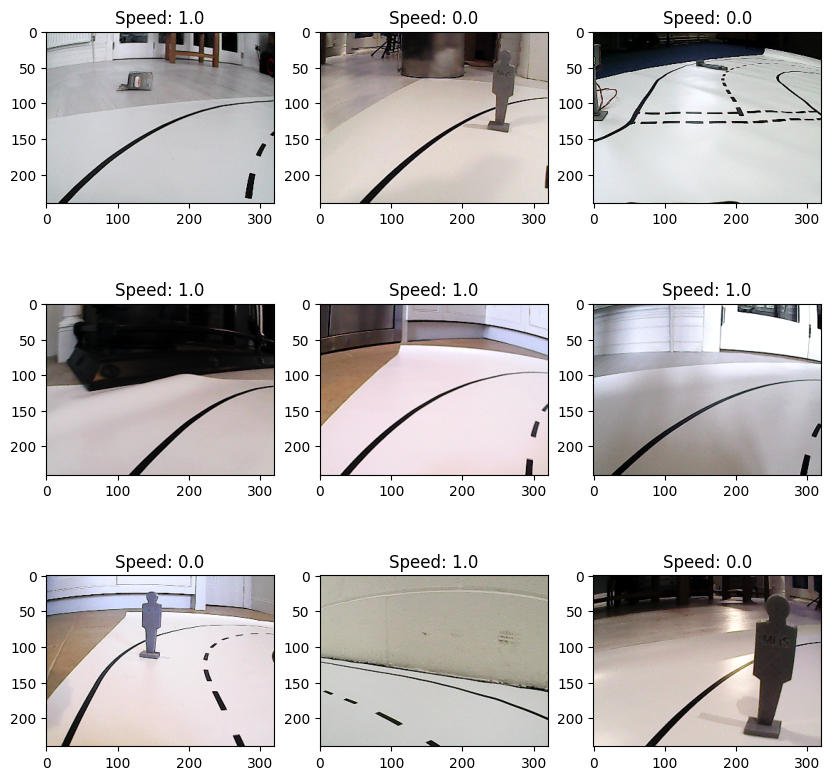

In [12]:
plt.figure(figsize=(10, 10))
i = 0

for image, speed in train_ds.take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("float32"))
    speed = speed.numpy()
    plt.title(f"Speed: {speed}")
    i += 1

In [13]:
def visualise(original, augmented):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Original image")
    plt.imshow(original.numpy().astype("float32"))

    plt.subplot(1, 2, 2)
    plt.title("Augmented image")
    plt.imshow(augmented.numpy().astype("float32"))

In [14]:
rotate_by_degree = 5
random_rotate = keras.layers.RandomRotation(rotate_by_degree / 360)


def augment(image, speed, seed=None):
    # Deal with the random seed
    if seed == None:
        seed = tf.random.uniform(shape=[2], maxval=10000, dtype=tf.int32)
    else:
        seed = tf.constant([seed, seed], dtype=tf.int32)

    image = tf.image.stateless_random_brightness(image, 0.3, seed)
    image = tf.image.stateless_random_contrast(image, 0.75, 1.25, seed)
    image = tf.image.stateless_random_hue(image, 0.05, seed)
    image = tf.image.stateless_random_saturation(image, 0.7, 1.2, seed)
    image = tf.image.stateless_random_jpeg_quality(image, 80, 100, seed)

    image = random_rotate(image)

    # crop image
    image = tf.image.stateless_random_crop(image, size=[210, 280, 3], seed=seed)

    # resize image back to 240x320
    image = tf.image.resize(image, [240, 320])

    return image, speed

Test augment function

20


2025-03-06 22:58:02.947160: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Augmented image shape: (240, 320, 3)


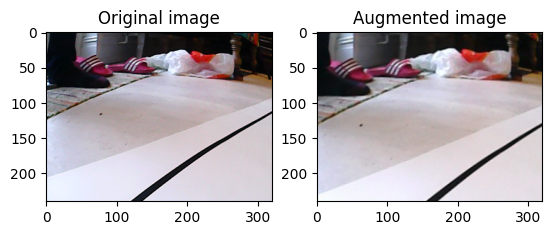

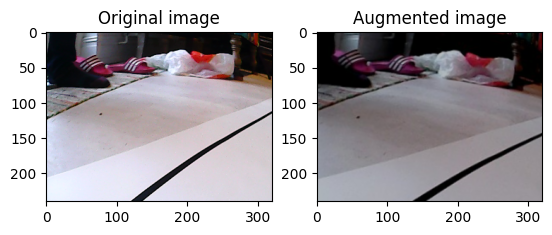

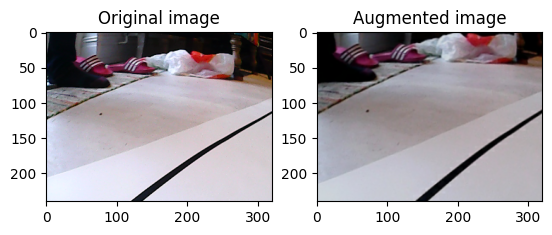

In [15]:
skip = 20
# skip+=1
print(skip)
for i in range(3):
    for image, speed in train_ds.skip(skip).take(1):
        augmented_image, speed = augment(image, speed, None)
        visualise(image, augmented_image)

for image, speed in train_ds.take(1):
    aug_image, aug_speed = augment(image, speed)
    print(f"Augmented image shape: {aug_image.shape}")

In [16]:
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [17]:
# def enhance_red(image, speed):
#     r, g, b = tf.split(image, num_or_size_splits=3, axis=-1)
#     r_mask = tf.logical_and((r*0.9 > g), (r*0.9 > b))
#     g_mask = tf.logical_and((g > r), (g > b))
#     b_mask = tf.logical_and((b > r), (b > g))
#     r = tf.where(r_mask, tf.clip_by_value(r * 1.5, 0.0, 1.0), r)
#     # g = g**2
#     # b = b**2
#     image = tf.concat([r, g, b], axis=-1)
#     return image, speed

# trian_ds = train_ds.map(enhance_red, num_parallel_calls=tf.data.AUTOTUNE)
# val_ds = val_ds.map(enhance_red, num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
def scale_ds(image, speed):
    # Range of input image: [0, 1]
    return image * 2 - 1.0, speed


train_ds = train_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)

In [19]:
def rephrase_ds(image, speed):
    # return image, {"speed1_output": speed, "speed2_output": speed, "speed3_output": speed}
    speed_dict = {}
    for i in range(10):
        speed_dict[f"speed{i}_output"] = speed

    return image, speed_dict

train_ds = train_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)

In [20]:
batch_size = 64


def configure_for_performance(ds, shuffle: bool, batch: bool):
    if shuffle:
        ds = ds.shuffle(buffer_size=3000)
    if batch:
        ds = ds.batch(batch_size, drop_remainder=True)
    else:
        ds = ds.batch(1, drop_remainder=False)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


train_ds = train_ds.repeat()
val_ds = val_ds.repeat()
train_ds = configure_for_performance(train_ds, shuffle=True, batch=True)
val_ds = configure_for_performance(val_ds, shuffle=False, batch=True)

### Build model

In [21]:
print(y_train)
class_weight = compute_class_weight("balanced", classes=np.array([0, 1]), y=y_train)
class_weight_dict = {0: class_weight[0], 1: class_weight[1]}
print(class_weight_dict)

[1. 0. 0. ... 0. 1. 1.]
{0: 2.076784101174345, 1: 0.6585505585792036}


In [22]:
image_shape = (240, 320, 3)

base_model = keras.applications.MobileNetV3Large(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape,
    pooling=None,
    include_preprocessing=False, 
)
base_model.trainable = False

print(base_model.output.shape)

(None, 8, 10, 960)


In [23]:
feature_extractor = base_model.output

print(feature_extractor.shape)

s_model = []

output_activation_1 = 'sigmoid'
output_activation_2 = 'linear'


# model 0
i = 0

s = feature_extractor
s = layers.Conv2D(128, (3, 3), (2, 2), padding='same', 
                  kernel_initializer='he_uniform', name=f's{i}_conv_2')(feature_extractor)
s = layers.BatchNormalization(name=f's{i}_bn_2')(s)
s = layers.Activation('relu', name=f's{i}_relu_2')(s)
s = layers.GlobalAveragePooling2D(name=f's{i}_GAP')(s)
s = layers.Dense(256, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_2')(s)
s = layers.Dropout(0.3, name=f's{i}_dropout_2')(s)
s = layers.Dense(64, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_1')(s)
s = layers.Dropout(0.3, name=f's{i}_dropout')(s)
s = layers.Dense(1, activation=output_activation_1, name=f's{i}_output')(s)

s_model.append(s)


# model 1
i += 1

s = feature_extractor
s = layers.Conv2D(384, (3, 3), (2, 2), padding='same', 
                  kernel_initializer='he_uniform', name=f's{i}_conv_1')(feature_extractor)
s = layers.BatchNormalization(name=f's{i}_bn_1')(s)
s = layers.Activation('relu', name=f's{i}_relu_1')(s)
s = layers.Conv2D(86, (3, 3), (2, 2), padding='same', 
                  kernel_initializer='he_uniform', name=f's{i}_conv_2')(s)
s = layers.BatchNormalization(name=f's{i}_bn_2')(s)
s = layers.Activation('relu', name=f's{i}_relu_2')(s)
s = layers.Flatten(name=f's{i}_flatten')(s)
s = layers.Dense(128, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_1')(s)
s = layers.Dropout(0.3, name=f's{i}_dropout')(s)
s = layers.Dense(1, activation=output_activation_1, name=f's{i}_output')(s)

s_model.append(s)


# model 2
i += 1

s = feature_extractor
s_attention = layers.Conv2D(1, (1, 1), padding='same', activation="sigmoid", name=f's{i}_attention_conv')(s)
s = layers.Multiply(name=f's{i}_attention_apply')([s, s_attention])
s = layers.Conv2D(86, (3, 3), (2, 2), padding='same', 
                  kernel_initializer='he_uniform', name=f's{i}_conv_1')(s)
s = layers.BatchNormalization(name=f's{i}_bn_1')(s)
s = layers.Activation('relu', name=f's{i}_relu_1')(s)
s = layers.GlobalAveragePooling2D(name=f's{i}_GAP')(s)
s = layers.Dense(256, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_2')(s)
s = layers.Dropout(0.3, name=f's{i}_dropout_2')(s)
s = layers.Dense(86, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_1')(s)
s = layers.Dropout(0.3, name=f's{i}_dropout')(s)
s = layers.Dense(1, activation=output_activation_1, name=f's{i}_output')(s)

s_model.append(s)


# model 3
i += 1

s = feature_extractor
s = layers.Conv2D(64, (3, 3), (2, 2), padding='same', name=f's{i}_conv_1')(s)
s = layers.BatchNormalization(name=f's{i}_bn_1')(s)
s = layers.Activation('relu', name=f's{i}_relu_1')(s)
s = layers.Flatten(name=f's{i}_flatten')(s)
s = layers.Dense(384, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_2')(s)
s = layers.Dropout(0.4, name=f's{i}_dropout_2')(s)
s = layers.Dense(32, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_1')(s)
s = layers.Dropout(0.1, name=f's{i}_dropout')(s)
s = layers.Dense(1, activation=output_activation_1, name=f's{i}_output')(s)

s_model.append(s)


# model 4
i += 1

s = feature_extractor
s_attention = layers.Conv2D(1, (1, 1), padding='same', activation="sigmoid", name=f's{i}_attention_conv')(s)
s = layers.Multiply(name=f's{i}_attention_apply')([s, s_attention])

# Spatial pyramid pooling
pool1 = layers.AveragePooling2D(pool_size=(1, 1), name=f's{i}_pool_1')(s)  # Full size
pool2 = layers.AveragePooling2D(pool_size=(2, 2), name=f's{i}_pool_2')(s)
up1 = layers.UpSampling2D(size=(1, 1), name=f's{i}_up_1')(pool1)
up2 = layers.UpSampling2D(size=(2, 2), name=f's{i}_up_2')(pool2)
s = layers.Concatenate(name=f's{i}_concat')([up1, up2])

s_up = s

# Conv to reduce channels
s = layers.Conv2D(48, (3, 3), padding='same', name=f's{i}_conv_1')(s)
s = layers.BatchNormalization(name=f's{i}_bn_1')(s)
s = layers.Activation('relu', name=f's{i}_relu_1')(s)
s = layers.GlobalAveragePooling2D(name=f's{i}_GAP')(s)

# Dense layers
s = layers.Dense(128, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_1')(s)
s = layers.Dropout(0.3, name=f's{i}_dropout')(s)
s = layers.Dense(1, activation=output_activation_1, name=f's{i}_output')(s)

s_model.append(s)



# model 5
i += 1

s = feature_extractor
# Spatial pyramid pooling
pool1 = layers.AveragePooling2D(pool_size=(1, 1), name=f's{i}_pool_1')(s)  # Full size
pool2 = layers.AveragePooling2D(pool_size=(2, 2), name=f's{i}_pool_2')(s)
up1 = layers.UpSampling2D(size=(1, 1), name=f's{i}_up_1')(pool1)
up2 = layers.UpSampling2D(size=(2, 2), name=f's{i}_up_2')(pool2)
s = layers.Concatenate(name=f's{i}_concat')([up1, up2])

s_up = s

# Conv to reduce channels
s = layers.Conv2D(48, (3, 3), padding='same', name=f's{i}_conv_1')(s)
s = layers.BatchNormalization(name=f's{i}_bn_1')(s)
s = layers.Activation('relu', name=f's{i}_relu_1')(s)
s = layers.GlobalAveragePooling2D(name=f's{i}_GAP')(s)

# Dense layers
s = layers.Dense(128, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_1')(s)
s = layers.Dropout(0.3, name=f's{i}_dropout')(s)
s = layers.Dense(1, activation=output_activation_1, name=f's{i}_output')(s)

s_model.append(s)


# model 6
i += 1

s = feature_extractor
s = layers.Conv2D(84, (3, 3), (2, 2), padding='same', 
                  kernel_initializer='he_uniform', name=f's{i}_conv_1')(s_up)
s = layers.BatchNormalization(name=f's{i}_bn_1')(s)
s = layers.Activation('relu', name=f's{i}_relu_1')(s)
s = layers.Flatten(name=f's{i}_flatten')(s)
s = layers.Dense(384, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_2')(s)
s = layers.Dropout(0.5, name=f's{i}_dropout_2')(s)
s = layers.Dense(72, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_1')(s)
s = layers.Dropout(0.3, name=f's{i}_dropout')(s)
s = layers.Dense(1, activation=output_activation_1, name=f's{i}_output')(s)

s_model.append(s)



# model 7
i += 1

s = feature_extractor
s = layers.Conv2D(64, (3, 3), (2, 2), padding='same', 
                  kernel_initializer='he_uniform', name=f's{i}_conv_1')(s)
s = layers.BatchNormalization(name=f's{i}_bn_1')(s)
s = layers.Activation('relu', name=f's{i}_relu_1')(s)
s = layers.Flatten(name=f's{i}_flatten')(s)
s = layers.Dense(256, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_2')(s)
s = layers.Dropout(0.4, name=f's{i}_dropout_2')(s)
s = layers.Dense(64, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_1')(s)
s = layers.Dropout(0.5, name=f's{i}_dropout')(s)
s = layers.Dense(1, activation=output_activation_1, name=f's{i}_output')(s)

s_model.append(s)


# model 8
i += 1

s = feature_extractor
s_attention = layers.Conv2D(1, (1, 1), padding='same', activation="sigmoid", name=f's{i}_attention_conv')(s)
s = layers.Multiply(name=f's{i}_attention_apply')([s, s_attention])
s = layers.Conv2D(64, (3, 3), (2, 2), padding='same', 
                  kernel_initializer='he_uniform', name=f's{i}_conv_1')(s)
s = layers.BatchNormalization(name=f's{i}_bn_1')(s)
s = layers.Activation('relu', name=f's{i}_relu_1')(s)
s = layers.Flatten(name=f's{i}_attention_flatten')(s)
s = layers.Dense(384, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_2')(s)
s = layers.Dropout(0.5, name=f's{i}_dropout_2')(s)
s = layers.Dense(64, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_1')(s)
s = layers.Dropout(0.5, name=f's{i}_dropout')(s)
s = layers.Dense(1, activation=output_activation_1, name=f's{i}_output')(s)

s_model.append(s)



# model 9
i += 1

s = feature_extractor
s = layers.Conv2D(86, (3, 3), (2, 2), padding='same', 
                  kernel_initializer='he_uniform', name=f's{i}_conv_1')(s)
s = layers.BatchNormalization(name=f's{i}_bn_1')(s)
s = layers.Activation('relu', name=f's{i}_relu_1')(s)
s_attention = layers.Conv2D(1, (1, 1), padding='same', activation="sigmoid", name=f's{i}_attention_conv')(s)
s = layers.Multiply(name=f's{i}_attention_apply')([s, s_attention])
s = layers.Flatten(name=f's{i}_flatten')(s)
s = layers.Dense(128, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_2')(s)
s = layers.Dropout(0.5, name=f's{i}_dropout_2')(s)
s = layers.Dense(32, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_1')(s)
s = layers.Dropout(0.3, name=f's{i}_dropout')(s)
s = layers.Dense(1, activation=output_activation_1, name=f's{i}_output')(s)

s_model.append(s)


outputs_dict = {}
loss_dict = {}
metrics_dict = {}

for i in range(len(s_model)):
    outputs_dict[f'speed{i}_output'] = s_model[i]
    loss_dict[f'speed{i}_output'] = WeightedBinaryCrossEntropy(class_weight_dict)
    # loss_dict[f'speed{i}_output'] = WeightedMeanSquaredError(class_weight_dict)
    metrics_dict[f'speed{i}_output'] = ["mse", "accuracy"]


model = Model(inputs=base_model.input, outputs=outputs_dict, name="speed_model")

learning_rate = 0.0010

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=loss_dict,
    metrics=metrics_dict,
)

# model.summary()

(None, 8, 10, 960)


In [24]:
sub_model = Model(inputs=feature_extractor, outputs=outputs_dict, 
                                                name="speed_model")
tf.keras.utils.plot_model(
    sub_model,
    show_shapes=True,  # Show input/output shapes
    show_layer_names=True,  # Show layer names (e.g., "angle_hidden_2")
    expand_nested=False,  # Keep it flat (no base_model nesting)
    show_layer_activations=True,
    dpi=96,  # Image resolution
)

print("Saved model image: model.png")

Saved model image: model.png


In [25]:
def lr_schedule(epoch, lr):
    FIRST_N_EPOCHS = 2
    
    initial_lr = learning_rate
    if epoch < FIRST_N_EPOCHS:
        return max(initial_lr * 2, 0.002)
    decay = 0.3
    return initial_lr / (1 + ((epoch-FIRST_N_EPOCHS) // 3) * decay)

for epoch in range(30):
    print(f"Epoch {epoch+1:2d}: {lr_schedule(epoch, 0):.6f}")

Epoch  1: 0.002000
Epoch  2: 0.002000
Epoch  3: 0.001000
Epoch  4: 0.001000
Epoch  5: 0.001000
Epoch  6: 0.000769
Epoch  7: 0.000769
Epoch  8: 0.000769
Epoch  9: 0.000625
Epoch 10: 0.000625
Epoch 11: 0.000625
Epoch 12: 0.000526
Epoch 13: 0.000526
Epoch 14: 0.000526
Epoch 15: 0.000455
Epoch 16: 0.000455
Epoch 17: 0.000455
Epoch 18: 0.000400
Epoch 19: 0.000400
Epoch 20: 0.000400
Epoch 21: 0.000357
Epoch 22: 0.000357
Epoch 23: 0.000357
Epoch 24: 0.000323
Epoch 25: 0.000323
Epoch 26: 0.000323
Epoch 27: 0.000294
Epoch 28: 0.000294
Epoch 29: 0.000294
Epoch 30: 0.000270


### Train model

In [26]:
current_epoch = 1
NUM_OF_EPOCHS = 10


checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="checkpoints/model_epoch_{epoch:02d}.keras",
    save_weights_only=False,
    save_freq="epoch",
    verbose=1,
)

# Use this lr_schedule when re-gen data every epoch
def lr_schedule(epoch, lr):
    FIRST_N_EPOCHS = 3
    epoch = current_epoch-1
    initial_lr = learning_rate
    if epoch < FIRST_N_EPOCHS:
        # return 0.002
        return max(initial_lr * 2, 0.002)
    elif epoch > 44:
        return 0.00005
    decay = 0.3
    return max(initial_lr / (1 + ((epoch-FIRST_N_EPOCHS) // 5) * decay), 0.0002)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)


history_callback = keras.callbacks.History()

outputs_dict = {}
loss_dict = {}
metrics_dict = {}

for i in range(len(s_model)):
    outputs_dict[f'speed{i}_output'] = s_model[i]
    loss_dict[f'speed{i}_output'] = WeightedMeanSquaredError(class_weight_dict)
    metrics_dict[f'speed{i}_output'] = ["mse", "accuracy"]

try:
    for i in range(NUM_OF_EPOCHS):
        print(f"\n{50*'*'}\nCurrent epoch: {current_epoch}", end="")

        # if current_epoch == 12: # change to WMSE
        #     print("\nChanging to W-MSE")
        #     model.compile(
        #         optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        #         loss=loss_dict,
        #         metrics=metrics_dict,
        #     )

        
        checkpoint = keras.callbacks.ModelCheckpoint(
            filepath=f"checkpoints/model_epoch_{current_epoch:02d}.keras",
            save_weights_only=False,
            save_freq="epoch",
            verbose=1,
        )
    
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=1,
            steps_per_epoch= train_ds_length // batch_size,
            validation_steps= val_ds_length // batch_size,
            callbacks=[checkpoint, history_callback, lr_scheduler],
            verbose=1,
        )

        current_epoch += 1

except KeyboardInterrupt:
    print("Stopped early—saving history")
    with open("training_history.pkl", "wb") as f:
        pickle.dump(history_callback.history, f)


**************************************************
Current epoch: 1
Epoch 1: LearningRateScheduler setting learning rate to 0.002.


2025-03-06 22:58:19.555978: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-03-06 22:58:19.722637: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-03-06 22:58:25.157228: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f40bab6faa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-06 22:58:25.157270: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-03-06 22:58:25.161392: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741301905.220878   40543 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/71 [==============================] - ETA: 0s - loss: 2.2526 - s0_output_loss: 0.1658 - s1_output_loss: 0.1860 - s2_output_loss: 0.1672 - s3_output_loss: 0.2151 - s4_output_loss: 0.1835 - s5_output_loss: 0.1661 - s6_output_loss: 0.2963 - s7_output_loss: 0.2504 - s8_output_loss: 0.3549 - s9_output_loss: 0.2672 - s0_output_mse: 0.0506 - s0_output_accuracy: 0.9278 - s1_output_mse: 0.0520 - s1_output_accuracy: 0.9285 - s2_output_mse: 0.0490 - s2_output_accuracy: 0.9322 - s3_output_mse: 0.0605 - s3_output_accuracy: 0.9142 - s4_output_mse: 0.0547 - s4_output_accuracy: 0.9241 - s5_output_mse: 0.0492 - s5_output_accuracy: 0.9318 - s6_output_mse: 0.0792 - s6_output_accuracy: 0.8902 - s7_output_mse: 0.0722 - s7_output_accuracy: 0.8992 - s8_output_mse: 0.1042 - s8_output_accuracy: 0.8545 - s9_output_mse: 0.0815 - s9_output_accuracy: 0.8812
Epoch 1: saving model to checkpoints/model_epoch_01.keras
71/71 [==============================] - 52s 373ms/step - loss: 2.2526 - s0_output_loss: 0.1658 - 

### Save model and plot

In [27]:
temp = history_callback.history
mse_dict = {}
for key in temp.keys():
  if key.endswith("mse"):
    # print(f"{key}: {temp[key][-1]}")
    mse_dict[key] = temp[key][-1]

for i in range(int(len(mse_dict)/2)):
  for key in mse_dict.keys():
    if str(i+1) in key:
      print(f"{key:20s}: {mse_dict[key]}")
#   print(list(mse_dict.keys())[i])
#   if mse_dict.keys[i].contains(i):
    # print(f"{mse_dict.keys()[i]}: {mse_dict[mse_dict.keys()[i]]}")

s1_output_mse       : 0.005147149320691824
val_s1_output_mse   : 0.014642605558037758
s2_output_mse       : 0.009085748344659805
val_s2_output_mse   : 0.016411708667874336
s3_output_mse       : 0.007332756649702787
val_s3_output_mse   : 0.016150275245308876
s4_output_mse       : 0.00926528126001358
val_s4_output_mse   : 0.01602114364504814
s5_output_mse       : 0.009582845494151115
val_s5_output_mse   : 0.015597729943692684
s6_output_mse       : 0.007647170219570398
val_s6_output_mse   : 0.015767626464366913
s7_output_mse       : 0.007757200393825769
val_s7_output_mse   : 0.01616579480469227
s8_output_mse       : 0.010179655626416206
val_s8_output_mse   : 0.016064079478383064
s9_output_mse       : 0.010410108603537083
val_s9_output_mse   : 0.021867750212550163


In [28]:
val_ds = tf.data.Dataset.from_tensor_slices((X_val_path, y_val))
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
# val_ds = val_ds.map(enhance_red, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = configure_for_performance(val_ds, shuffle=False, batch=False)

# model = keras.models.load_model(
#     "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/checkpoints/model_epoch_06.keras",
#     custom_objects={"WeightedMeanSquaredError": WeightedMeanSquaredError},
# )

pred = model.predict(val_ds)

9195/9195 [==============================] - 107s 11ms/step


In [29]:
y_pred = []
for key in pred.keys():
    print(key, end=", ")
    temp = (pred[key][:, 0])
    y_pred.append(temp)
print()

y_pred_mean = np.mean(y_pred, axis=0)

uncertain = []

for yp in y_pred:
    for i in range(len(X_val)):
        if np.abs(yp[i]-0.5)<0.3:
            uncertain.append(X_val[i])

uncertain = np.array(uncertain)

print(len(np.unique(uncertain)))

pd.DataFrame({"image_id": np.unique(uncertain)}).to_csv("uncertain_1.csv", index=False)

speed0_output, speed1_output, speed2_output, speed3_output, speed4_output, speed5_output, speed6_output, speed7_output, speed8_output, speed9_output, 
702
